# Exploring Global Weather Forecasts with Zarr on Google Cloud Storage and WeatherNext 2

**Welcome!** This notebook introduces a weather forecast dataset available in Zarr format on Google Cloud Storage, generated by Google DeepMind and Google Research's WeatherNext 2 model. Through a series of sample queries, we'll demonstrate how to access, analyze, and visualize this data to gain insights into global weather patterns, trends, and potential impacts.

**Dataset Overview**

This dataset offers weather forecasts produced by WeatherNext 2, a state-of-the-art machine learning model developed by Google DeepMind and Google Research. It provides predictions for various weather variables, including temperature, precipitation, wind speed, and more, at a global scale and with a high degree of accuracy. Each forecast consists of 64 ensemble members, representing 64 different possible outcomes.

**Notebook Purpose**

This notebook aims to:

* Familiarize users with the structure and content of the WeatherNext 2 weather forecast dataset in Zarr.
* Demonstrate how to query and analyze this data using the Xarray library's powerful tools and functions.
* Showcase the potential applications of this data for various weather-related tasks, such as forecasting, climate analysis, and risk assessment.

**Copyright Information**

Copyright 2025 Google LLC.

All materials are licensed under the [Creative Commons Attribution 4.0 International License (CC-BY)](https://creativecommons.org/licenses/by/4.0/legalcode).

**Additional Documentation**

[Xarray Library Documentation](https://docs.xarray.dev)

## Import Python Libraries & Some Other Setup

In [1]:
!pip install rioxarray zarr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 65.8 MB/s eta 0:00:00


In [2]:
from collections.abc import Mapping

import gcsfs
from google.colab import auth
import folium
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import rioxarray
import shapely
import seaborn as sns
import numpy as np
import xarray as xr
import zarr

import warnings
# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

## Set Google Cloud Project ID

In [3]:
project_id = 'ee-manmeet20singh15-wbis' #@param{type:"string"}

# Weather Forecast Dataset Schema

This describes the schema for a weather forecast dataset.

## Dimensions

<div align="left">

| Name | Type | Description |
| --- | --- | --- |
| `lat` | float32 | The latitude of the forecast. |
| `level`  | int64 | The pressure level, e.g., 50, 100... 1000 hPa. For surface-level variables, this is 0. |
| `lon` | float32 | The longitude of the forecast. |
| `sample` | int64 | The ID of the member in the ensemble. |
| `time` | timedelta64[ns] | The forecast lead time. Represents the number of hours from the init time (as indicated in the zarr filename).

</div>

## Variables

<div align="left">

| Name | Units | Description |
|---|---|---|
| `total_precipitation_6hr` | m | Total precipitation over a 6-hour period |
| `10m_u_component_of_wind` | m/s | The u-component of wind at 10 meters above the surface |
| `10m_v_component_of_wind` | m/s | The v-component of wind at 10 meters above the surface |
| `100m_u_component_of_wind` | m/s | The u-component of wind at 100 meters above the surface |
| `100m_v_component_of_wind` | m/s | The v-component of wind at 100 meters above the surface |
| `2m_temperature` | K | Temperature at 2 meters above the surface |
| `mean_sea_level_pressure` | Pa | Mean sea level pressure |

There are also values for the following variables at various pressure levels (50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000 hPa). They are stored along the `level` dimension:

| Name | Units | Description |
|---|---|---|
| `geopotential` | m^2/s^2 | Geopotential |
| `specific_humidity` | kg/kg | Specific humidity |
| `temperature` | K | Temperature |
| `u_component_of_wind` | m/s | The u-component of wind |
| `v_component_of_wind` | m/s | The v-component of wind |
| `vertical_velocity` | Pa/s | Vertical velocity |

</div>

# Example Queries

First, let's open the zarr dataset in GCS for a specific init timestamp (2025-10-03 00:00 UTC).

In [4]:
from google.cloud import storage

auth.authenticate_user()

fs = gcsfs.GCSFileSystem(project=project_id, token='cloud')
zstore = zarr.storage.FsspecStore(
    fs,
    path="weathernext/weathernext_2_0_0/zarr/2025_to_present/20251003_00hr_01_preds/predictions.zarr"
)

ds = xr.open_zarr(zstore)

# Show schema
ds

/tmp/ipython-input-4237540093.py:6: ZarrUserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x7e5167a47ef0>) was not created with `asynchronous=True`, this may lead to surprising behavior
  zstore = zarr.storage.FsspecStore(
/usr/local/lib/python3.12/dist-packages/zarr/storage/_fsspec.py:249: ZarrUserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x7e5167a47ef0>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return type(self)(


<xarray.Dataset> Size: 1TB
Dimensions:                   (sample: 64, time: 60, lat: 721, lon: 1440,
                               level: 13)
Coordinates:
  * sample                    (sample) int64 512B 0 1 2 3 4 5 ... 59 60 61 62 63
  * time                      (time) timedelta64[ns] 480B 0 days 06:00:00 ......
  * lat                       (lat) float32 3kB -90.0 -89.75 ... 89.75 90.0
  * lon                       (lon) float32 6kB 0.0 0.25 0.5 ... 359.5 359.8
  * level                     (level) int32 52B 50 100 150 200 ... 850 925 1000
    datetime                  (time) datetime64[ns] 480B dask.array<chunksize=(60,), meta=np.ndarray>
    init_time                 datetime64[ns] 8B ...
Data variables: (12/14)
    100m_u_component_of_wind  (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind  (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind   (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind   (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    2m_temperature            (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    geopotential              (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>
    ...                        ...
    specific_humidity         (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>
    temperature               (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>
    total_precipitation_6hr   (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    u_component_of_wind       (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>
    v_component_of_wind       (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>
    vertical_velocity         (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>

## Exploring Temperature Forecasts for New York City - 5 Day

This query retrieves the 2-meter temperature forecasts for New York, NY, across all the ensemble members for the given init time, demonstrating how to access and analyze the core weather data in the dataset.

In [25]:
# Note: longitudes in this dataset use 0-360 range.
nyc_polygon = shapely.geometry.Polygon([(289.34, 40.64), (286.15, 40.64), (286.15, 40.89), (289.34, 40.89), (289.34, 40.64)])

nyc_ds = ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
nyc_ds.rio.write_crs("EPSG:4326", inplace=True)
nyc_ds = nyc_ds.rio.clip([nyc_polygon], crs="EPSG:4326")

# Show schema for clipped dataset
nyc_ds

<xarray.Dataset> Size: 17MB
Dimensions:                   (time: 60, lat: 1, lon: 13, sample: 64, level: 13)
Coordinates:
  * time                      (time) timedelta64[ns] 480B 0 days 06:00:00 ......
  * lat                       (lat) float32 4B 40.75
  * lon                       (lon) float32 52B 286.2 286.5 ... 289.0 289.2
  * sample                    (sample) int64 512B 0 1 2 3 4 5 ... 59 60 61 62 63
  * level                     (level) int32 52B 50 100 150 200 ... 850 925 1000
    datetime                  (time) datetime64[ns] 480B dask.array<chunksize=(60,), meta=np.ndarray>
    init_time                 datetime64[ns] 8B ...
    spatial_ref               int64 8B 0
Data variables: (12/14)
    100m_u_component_of_wind  (sample, time, lat, lon) float32 200kB dask.array<chunksize=(1, 1, 1, 13), meta=np.ndarray>
    100m_v_component_of_wind  (sample, time, lat, lon) float32 200kB dask.array<chunksize=(1, 1, 1, 13), meta=np.ndarray>
    10m_u_component_of_wind   (sample, time, lat, lon) float32 200kB dask.array<chunksize=(1, 1, 1, 13), meta=np.ndarray>
    10m_v_component_of_wind   (sample, time, lat, lon) float32 200kB dask.array<chunksize=(1, 1, 1, 13), meta=np.ndarray>
    2m_temperature            (sample, time, lat, lon) float32 200kB dask.array<chunksize=(1, 1, 1, 13), meta=np.ndarray>
    geopotential              (sample, time, level, lat, lon) float32 3MB dask.array<chunksize=(1, 1, 1, 1, 13), meta=np.ndarray>
    ...                        ...
    specific_humidity         (sample, time, level, lat, lon) float32 3MB dask.array<chunksize=(1, 1, 1, 1, 13), meta=np.ndarray>
    temperature               (sample, time, level, lat, lon) float32 3MB dask.array<chunksize=(1, 1, 1, 1, 13), meta=np.ndarray>
    total_precipitation_6hr   (sample, time, lat, lon) float32 200kB dask.array<chunksize=(1, 1, 1, 13), meta=np.ndarray>
    u_component_of_wind       (sample, time, level, lat, lon) float32 3MB dask.array<chunksize=(1, 1, 1, 1, 13), meta=np.ndarray>
    v_component_of_wind       (sample, time, level, lat, lon) float32 3MB dask.array<chunksize=(1, 1, 1, 1, 13), meta=np.ndarray>
    vertical_velocity         (sample, time, level, lat, lon) float32 3MB dask.array<chunksize=(1, 1, 1, 1, 13), meta=np.ndarray>

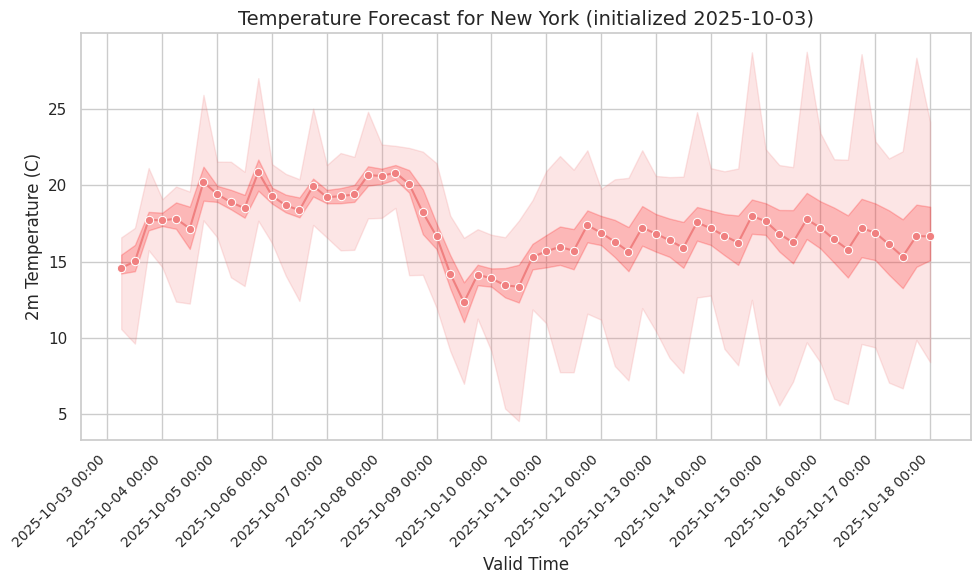

In [21]:
# Generating the plot can take up to 5 minutes.

# Stack the 2m_temperature values so we can get a 1D array for plotting purposes.
nyc_temps = nyc_ds['2m_temperature'].stack(stacked_2m_temperature=('lat', 'lon', 'sample', 'time'))

# Programatically determine the init_time and get it in string format to display
# as the plot title. There should only be a single init_time in this dataset.
forecast_date = np.datetime_as_string(nyc_temps['init_time'].values, unit='D')

# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Plot the data
# This will display a graph with a line representing the average temp, and
# error bars representing the min and max for each forecast time.
# The average temp is the average across all ensembles AND all points inside
# NYC.
# The average is implicitly calculated by the plotting library.

plt.figure(figsize=(10, 6))

# Avg with min and max band
def min_max_err(x):
  return (x.min(), x.max())
sns.lineplot(
    x=mdates.date2num(nyc_temps['datetime']),
    y=nyc_temps - 273.15,
    errorbar=min_max_err,
    marker='o',
    linestyle='-',
    color='lightcoral'
)

# 50th percentile band
sns.lineplot(
    x=mdates.date2num(nyc_temps['datetime'].values),
    y=nyc_temps - 273.15,
    errorbar=('pi', 50),
    marker='',
    linestyle='',
    color='red'
)

plt.xlabel('Valid Time', fontsize=12)
plt.ylabel('2m Temperature (C)', fontsize=12)
plt.title(f'Temperature Forecast for New York (initialized {forecast_date})', fontsize=14)

# Format the x-axis ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Show date and time
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show ticks for each day
plt.xticks(rotation=45, ha='right', fontsize=10)

plt.tight_layout()
plt.show()

## Deterministic forecasts

The forecasts produced by WeatherNext 2 consist of ensembles. To get a single deterministic forecast, you can average the values across all the ensembles, as in the following example:

### World - 10/03/2025 06:00 Hours
This query gets the values for all variables averaged over all ensemble members in a single forecast (specifically, with an init time of 2025-10-03 00:00 and valid time of 2025-10-03 06:00).

In contrast to the previous example, the average is calculated in the xarray query, and not by the plotting library.

In [22]:
world_avgs = ds.sel(time='6h').mean(dim='sample')

# Show dataset schema. Note how the "sample" dimension has been dropped after
# calling `mean` on that dimension.
world_avgs

<xarray.Dataset> Size: 357MB
Dimensions:                   (lat: 721, lon: 1440, level: 13)
Coordinates:
  * lat                       (lat) float32 3kB -90.0 -89.75 ... 89.75 90.0
  * lon                       (lon) float32 6kB 0.0 0.25 0.5 ... 359.5 359.8
  * level                     (level) int32 52B 50 100 150 200 ... 850 925 1000
    datetime                  datetime64[ns] 8B dask.array<chunksize=(), meta=np.ndarray>
    init_time                 datetime64[ns] 8B ...
    time                      timedelta64[ns] 8B 06:00:00
    spatial_ref               int64 8B 0
Data variables: (12/14)
    100m_u_component_of_wind  (lat, lon) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    100m_v_component_of_wind  (lat, lon) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    10m_u_component_of_wind   (lat, lon) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    10m_v_component_of_wind   (lat, lon) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    2m_temperature            (lat, lon) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    geopotential              (level, lat, lon) float32 54MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ...                        ...
    specific_humidity         (level, lat, lon) float32 54MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    temperature               (level, lat, lon) float32 54MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    total_precipitation_6hr   (lat, lon) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    u_component_of_wind       (level, lat, lon) float32 54MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    v_component_of_wind       (level, lat, lon) float32 54MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    vertical_velocity         (level, lat, lon) float32 54MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>


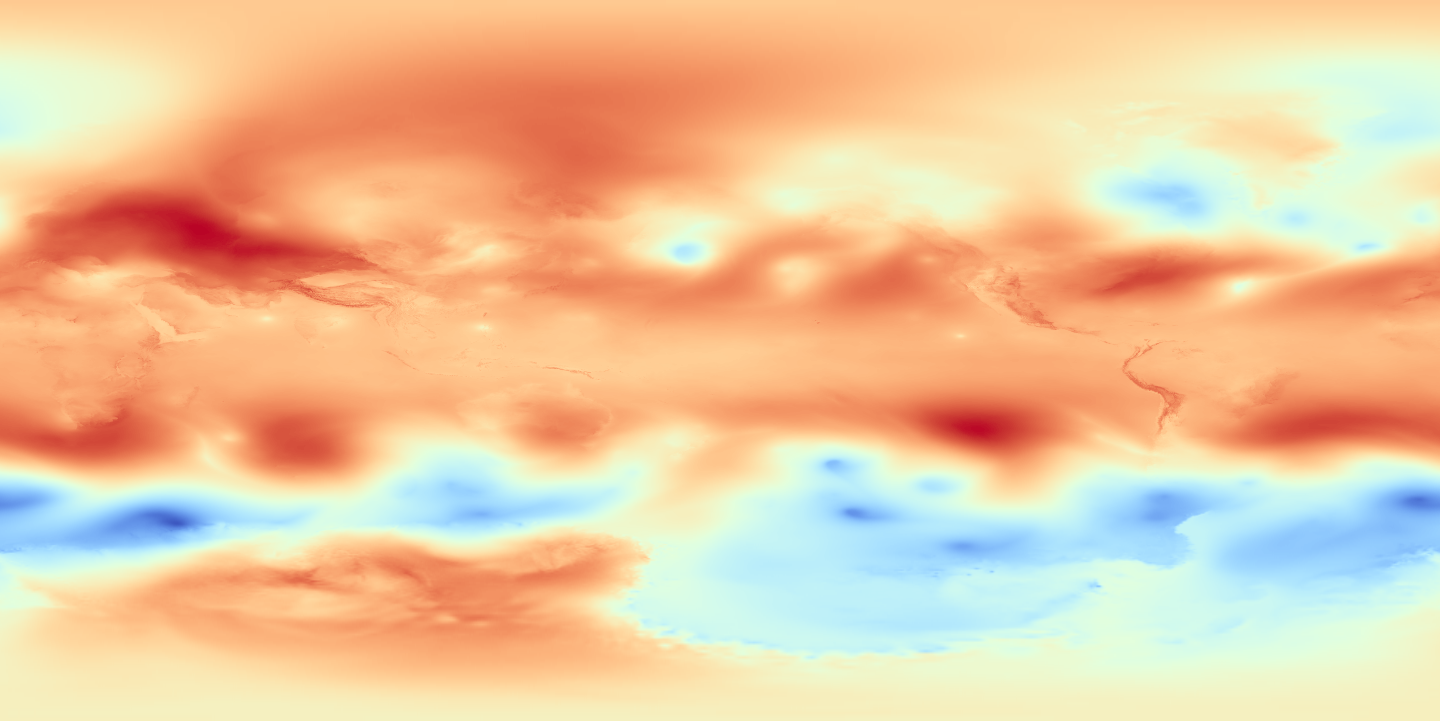

In [24]:
# Map display options
variable = "mean_sea_level_pressure"  # @param ["2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind", "100m_u_component_of_wind", "100m_v_component_of_wind", "mean_sea_level_pressure", "sea_surface_temperature", "total_precipitation_6hr", "geopotential", "specific_humidity", "temperature", "u_component_of_wind", "v_component_of_wind", "vertical_velocity"]
# If surface-level variable, leave as N/A.
level = "N/A"  # @param ["N/A", 50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]
palette = "coolwarm"   # @param ["coolwarm", "Spectral_r", "BuPu"]
pixelated = False  # @param {type:"boolean"}

var_avg = world_avgs[variable]
if level != "N/A":
  var_avg = var_avg.sel(level=int(level))

# Convert points to an image

# First, get the lat, lon, and variable avg values as 1d arrays.
var_avg = var_avg.stack(lat_lon=('lat', 'lon'))
x = var_avg['lon'].values
y = var_avg['lat'].values
z = var_avg.values

ny = len(np.unique(y))
nx = len(np.unique(x))

# Bin the data onto a regular grid
zi, xi, yi = np.histogram2d(x, y, bins=(nx, ny), weights=z)
counts, _, _ = np.histogram2d(x, y, bins=(nx, ny))

zi = zi / counts
zi = np.ma.masked_invalid(zi)

# Generate colors for the image
cm = matplotlib.colormaps[palette]
normed_data = (zi - zi.min()) / (zi.max() - zi.min())
# Rotate 90 deg counterclockwise so the image will be oriented correctly
# (Folium uses lat, lon instead of lon, lat).
z = cm(np.rot90(normed_data))

# Create a base map
m = folium.Map(location=[30, 180], zoom_start=2)

# Add temperature image
folium.raster_layers.ImageOverlay(
    image=z,
    bounds=[[float(yi.min()), float(xi.min())], [float(yi.max()), float(xi.max())]],
    mercator_project=True,
    pixelated=pixelated,
    opacity=0.5,
).add_to(m)

# Display the map
m

# Task
Load the Zarr dataset from Google Cloud Storage for the initial condition '20251208_00hr_01_preds' into a new xarray dataset variable `ds_20251208_00utc`, and confirm the data has been successfully loaded.

## Load Data for 2025-12-09 00 UTC

### Subtask:
Load the Zarr dataset from Google Cloud Storage for the initial condition '20251209_00hr_01_preds' into a new xarray dataset variable `ds_20251208_00utc`.


**Reasoning**:
I will load the new Zarr dataset for the specified initial condition into the `ds_20251209_00utc` variable and display its schema.



In [5]:
from google.cloud import storage

auth.authenticate_user()

fs = gcsfs.GCSFileSystem(project=project_id, token='cloud')

zstore_20251209 = zarr.storage.FsspecStore(
    fs,
    path="weathernext/weathernext_2_0_0/zarr/2025_to_present/20251209_00hr_01_preds/predictions.zarr"
)

ds_20251209_00utc = xr.open_zarr(zstore_20251209)

# Show schema
ds_20251209_00utc

/tmp/ipython-input-1270314538.py:7: ZarrUserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x7a7baaf46ab0>) was not created with `asynchronous=True`, this may lead to surprising behavior
  zstore_20251209 = zarr.storage.FsspecStore(
/usr/local/lib/python3.12/dist-packages/zarr/storage/_fsspec.py:249: ZarrUserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x7a7baaf46ab0>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return type(self)(


<xarray.Dataset> Size: 1TB
Dimensions:                   (sample: 64, time: 60, lat: 721, lon: 1440,
                               level: 13)
Coordinates:
  * sample                    (sample) int64 512B 0 1 2 3 4 5 ... 59 60 61 62 63
  * time                      (time) timedelta64[ns] 480B 0 days 06:00:00 ......
  * lat                       (lat) float32 3kB -90.0 -89.75 ... 89.75 90.0
  * lon                       (lon) float32 6kB 0.0 0.25 0.5 ... 359.5 359.8
  * level                     (level) int32 52B 50 100 150 200 ... 850 925 1000
    datetime                  (time) datetime64[ns] 480B dask.array<chunksize=(60,), meta=np.ndarray>
    init_time                 datetime64[ns] 8B ...
Data variables: (12/14)
    100m_u_component_of_wind  (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind  (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind   (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind   (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    2m_temperature            (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    geopotential              (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>
    ...                        ...
    specific_humidity         (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>
    temperature               (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>
    total_precipitation_6hr   (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    u_component_of_wind       (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>
    v_component_of_wind       (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>
    vertical_velocity         (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>

In [6]:
#ds_20251209_00utc.to_netcdf('weathernext2_2025120900utc.nc')

**Reasoning**:
The previous code block successfully loaded the Zarr dataset into `ds_20251209_00utc` and displayed its schema, fulfilling the subtask requirements.



# Task
Create a GIF of the 15-day total precipitation forecast for Kentucky, with each frame showing the 6-hour precipitation distribution, and present it with a summary.

## Clip Data for Kentucky

### Subtask:
Using the already loaded `ds_20251208_00utc` dataset, clip the data to the approximate geographical boundaries of Kentucky. This will create a `kentucky_ds` dataset containing only the region of interest for the precipitation forecast.


**Reasoning**:
I will define the Kentucky polygon, set spatial dimensions, write the CRS, clip the dataset, and then display its schema to confirm the clipping operation was successful, as per the instructions.



In [8]:
kentucky_polygon = shapely.geometry.Polygon([(270, 36.5), (270, 39.2), (277, 39.2), (277, 36.5), (270, 36.5)])

kentucky_ds = ds_20251209_00utc.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
kentucky_ds.rio.write_crs("EPSG:4326", inplace=True)
kentucky_ds = kentucky_ds.rio.clip([kentucky_polygon], crs="EPSG:4326")

# Show schema for clipped dataset
kentucky_ds

<xarray.Dataset> Size: 407MB
Dimensions:                   (time: 60, lat: 11, lon: 28, sample: 64, level: 13)
Coordinates:
  * time                      (time) timedelta64[ns] 480B 0 days 06:00:00 ......
  * lat                       (lat) float32 44B 36.5 36.75 37.0 ... 38.75 39.0
  * lon                       (lon) float32 112B 270.2 270.5 ... 276.8 277.0
  * sample                    (sample) int64 512B 0 1 2 3 4 5 ... 59 60 61 62 63
  * level                     (level) int32 52B 50 100 150 200 ... 850 925 1000
    datetime                  (time) datetime64[ns] 480B dask.array<chunksize=(60,), meta=np.ndarray>
    init_time                 datetime64[ns] 8B ...
    spatial_ref               int64 8B 0
Data variables: (12/14)
    100m_u_component_of_wind  (sample, time, lat, lon) float32 5MB dask.array<chunksize=(1, 1, 11, 28), meta=np.ndarray>
    100m_v_component_of_wind  (sample, time, lat, lon) float32 5MB dask.array<chunksize=(1, 1, 11, 28), meta=np.ndarray>
    10m_u_component_of_wind   (sample, time, lat, lon) float32 5MB dask.array<chunksize=(1, 1, 11, 28), meta=np.ndarray>
    10m_v_component_of_wind   (sample, time, lat, lon) float32 5MB dask.array<chunksize=(1, 1, 11, 28), meta=np.ndarray>
    2m_temperature            (sample, time, lat, lon) float32 5MB dask.array<chunksize=(1, 1, 11, 28), meta=np.ndarray>
    geopotential              (sample, time, level, lat, lon) float32 62MB dask.array<chunksize=(1, 1, 1, 11, 28), meta=np.ndarray>
    ...                        ...
    specific_humidity         (sample, time, level, lat, lon) float32 62MB dask.array<chunksize=(1, 1, 1, 11, 28), meta=np.ndarray>
    temperature               (sample, time, level, lat, lon) float32 62MB dask.array<chunksize=(1, 1, 1, 11, 28), meta=np.ndarray>
    total_precipitation_6hr   (sample, time, lat, lon) float32 5MB dask.array<chunksize=(1, 1, 11, 28), meta=np.ndarray>
    u_component_of_wind       (sample, time, level, lat, lon) float32 62MB dask.array<chunksize=(1, 1, 1, 11, 28), meta=np.ndarray>
    v_component_of_wind       (sample, time, level, lat, lon) float32 62MB dask.array<chunksize=(1, 1, 1, 11, 28), meta=np.ndarray>
    vertical_velocity         (sample, time, level, lat, lon) float32 62MB dask.array<chunksize=(1, 1, 1, 11, 28), meta=np.ndarray>

In [12]:
kentucky_ds_ = kentucky_ds.total_precipitation_6hr.to_dataset().compute()
kentucky_ds_

<xarray.Dataset> Size: 5MB
Dimensions:                  (time: 60, lat: 11, lon: 28, sample: 64)
Coordinates:
  * time                     (time) timedelta64[ns] 480B 0 days 06:00:00 ... ...
  * lat                      (lat) float32 44B 36.5 36.75 37.0 ... 38.75 39.0
  * lon                      (lon) float32 112B 270.2 270.5 ... 276.8 277.0
  * sample                   (sample) int64 512B 0 1 2 3 4 5 ... 59 60 61 62 63
    datetime                 (time) datetime64[ns] 480B 2025-12-09T06:00:00 ....
    init_time                datetime64[ns] 8B 2025-12-09
    spatial_ref              int64 8B 0
Data variables:
    total_precipitation_6hr  (sample, time, lat, lon) float32 5MB -3.682e-07 ...

In [13]:
kentucky_ds_.to_netcdf('kentucky_ds.nc')

In [14]:
!ls -lrt

total 4644
drwxr-xr-x 1 root root    4096 Nov 20 14:30 sample_data
-rw-r--r-- 1 root root 4748978 Dec  9 21:15 kentucky_ds.nc


# Task
**Task**: Adjust the `kentucky_polygon` to extend its eastern boundary from 277 degrees longitude to 279 degrees longitude. Then, re-clip the `ds_20251209_00utc` dataset using this adjusted polygon to create an updated `kentucky_ds` dataset. Display the schema of the new `kentucky_ds` to verify the updated clipping.

## Clip Data for Kentucky (Adjusted Boundaries)

### Subtask:
Using the already loaded `ds_20251208_00utc` dataset, clip the data to the adjusted geographical boundaries of Kentucky. I will modify the `kentucky_polygon` to extend further east to ensure all of Eastern Kentucky is included. This will create a `kentucky_ds` dataset containing only the region of interest for the precipitation forecast.


**Reasoning**:
I will redefine the Kentucky polygon with the adjusted eastern longitude, then clip the dataset using this new polygon, and finally display the schema to verify the clipping was successful and covers the expanded area.



In [7]:
kentucky_polygon = shapely.geometry.Polygon([(270, 36.5), (270, 39.2), (279, 39.2), (279, 36.5), (270, 36.5)])

kentucky_ds = ds_20251209_00utc.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
kentucky_ds.rio.write_crs("EPSG:4326", inplace=True)
kentucky_ds = kentucky_ds.rio.clip([kentucky_polygon], crs="EPSG:4326")

# Show schema for clipped dataset
kentucky_ds

<xarray.Dataset> Size: 523MB
Dimensions:                   (time: 60, lat: 11, lon: 36, sample: 64, level: 13)
Coordinates:
  * time                      (time) timedelta64[ns] 480B 0 days 06:00:00 ......
  * lat                       (lat) float32 44B 36.5 36.75 37.0 ... 38.75 39.0
  * lon                       (lon) float32 144B 270.2 270.5 ... 278.8 279.0
  * sample                    (sample) int64 512B 0 1 2 3 4 5 ... 59 60 61 62 63
  * level                     (level) int32 52B 50 100 150 200 ... 850 925 1000
    datetime                  (time) datetime64[ns] 480B dask.array<chunksize=(60,), meta=np.ndarray>
    init_time                 datetime64[ns] 8B ...
    spatial_ref               int64 8B 0
Data variables: (12/14)
    100m_u_component_of_wind  (sample, time, lat, lon) float32 6MB dask.array<chunksize=(1, 1, 11, 36), meta=np.ndarray>
    100m_v_component_of_wind  (sample, time, lat, lon) float32 6MB dask.array<chunksize=(1, 1, 11, 36), meta=np.ndarray>
    10m_u_component_of_wind   (sample, time, lat, lon) float32 6MB dask.array<chunksize=(1, 1, 11, 36), meta=np.ndarray>
    10m_v_component_of_wind   (sample, time, lat, lon) float32 6MB dask.array<chunksize=(1, 1, 11, 36), meta=np.ndarray>
    2m_temperature            (sample, time, lat, lon) float32 6MB dask.array<chunksize=(1, 1, 11, 36), meta=np.ndarray>
    geopotential              (sample, time, level, lat, lon) float32 79MB dask.array<chunksize=(1, 1, 1, 11, 36), meta=np.ndarray>
    ...                        ...
    specific_humidity         (sample, time, level, lat, lon) float32 79MB dask.array<chunksize=(1, 1, 1, 11, 36), meta=np.ndarray>
    temperature               (sample, time, level, lat, lon) float32 79MB dask.array<chunksize=(1, 1, 1, 11, 36), meta=np.ndarray>
    total_precipitation_6hr   (sample, time, lat, lon) float32 6MB dask.array<chunksize=(1, 1, 11, 36), meta=np.ndarray>
    u_component_of_wind       (sample, time, level, lat, lon) float32 79MB dask.array<chunksize=(1, 1, 1, 11, 36), meta=np.ndarray>
    v_component_of_wind       (sample, time, level, lat, lon) float32 79MB dask.array<chunksize=(1, 1, 1, 11, 36), meta=np.ndarray>
    vertical_velocity         (sample, time, level, lat, lon) float32 79MB dask.array<chunksize=(1, 1, 1, 11, 36), meta=np.ndarray>

## Aggregate Daily Precipitation for Kentucky

### Subtask:
Starting from the `kentucky_ds` dataset (which is already clipped to Kentucky), select the 'total_precipitation_6hr' variable. First, calculate the mean across all ensemble members (`sample` dimension) to get a deterministic forecast. Then, resample this 6-hourly data to daily sums (`'1D'`) to get the total daily precipitation. Finally, convert the units from meters to millimeters for easier interpretation.


**Reasoning**:
I will select the 'total_precipitation_6hr' variable from the `kentucky_ds` dataset, compute the mean across ensemble members, resample to daily sums, convert to millimeters, and display the schema to confirm the aggregation.



In [14]:
kentucky_daily_precip_mm = kentucky_ds['total_precipitation_6hr'].mean(dim='sample').resample(time='1D').sum() * 1000
kentucky_daily_precip_mm = kentucky_daily_precip_mm.compute()

In [16]:
kentucky_daily_precip_mm.to_dataset()

<xarray.Dataset> Size: 24kB
Dimensions:                  (lat: 11, lon: 36, time: 15)
Coordinates:
  * lat                      (lat) float32 44B 36.5 36.75 37.0 ... 38.75 39.0
  * lon                      (lon) float32 144B 270.2 270.5 ... 278.8 279.0
  * time                     (time) timedelta64[ns] 120B 0 days 06:00:00 ... ...
    init_time                datetime64[ns] 8B 2025-12-09
    spatial_ref              int64 8B 0
Data variables:
    total_precipitation_6hr  (time, lat, lon) float32 24kB 0.001659 ... 4.728

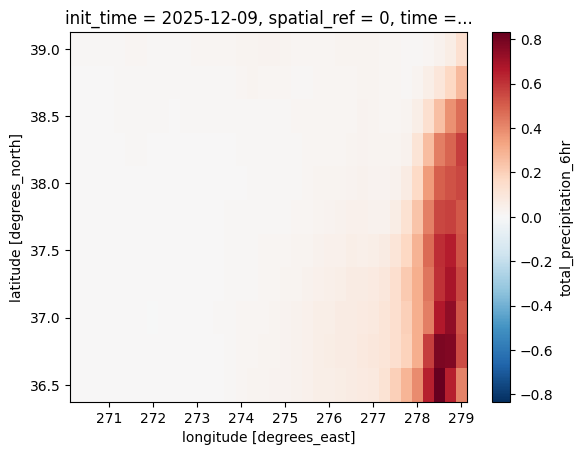

In [17]:
kentucky_daily_precip_mm.isel(time=0).plot()

In [20]:
kentucky_daily_precip_mm.to_dataset().to_netcdf('kentucky_daily_precip_mm.nc')

# Task
Load the Zarr dataset from Google Cloud Storage for the initial condition '20251210_00hr_01_preds' into a new xarray dataset variable, `ds_20251210_00utc`. Then, from `ds_20251210_00utc`, select the variables `total_precipitation_6hr`, `2m_temperature`, `10m_u_component_of_wind`, and `10m_v_component_of_wind`. Display the schema of this new dataset containing only the selected surface/near-surface variables.

## Load Data for 2025-12-10 00 UTC

### Subtask:
Load the Zarr dataset from Google Cloud Storage for the initial condition '20251210_00hr_01_preds' into a new xarray dataset variable, `ds_20251210_00utc`.


**Reasoning**:
I will load the new Zarr dataset for the specified initial condition into the `ds_20251210_00utc` variable and display its schema.



In [5]:
from google.cloud import storage

auth.authenticate_user()

fs = gcsfs.GCSFileSystem(project=project_id, token='cloud')

zstore_20251210 = zarr.storage.FsspecStore(
    fs,
    path="weathernext/weathernext_2_0_0/zarr/2025_to_present/20251210_00hr_01_preds/predictions.zarr"
)

ds_20251210_00utc = xr.open_zarr(zstore_20251210)

# Show schema
ds_20251210_00utc

/tmp/ipython-input-1611547392.py:7: ZarrUserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x7e5167a47ef0>) was not created with `asynchronous=True`, this may lead to surprising behavior
  zstore_20251210 = zarr.storage.FsspecStore(
/usr/local/lib/python3.12/dist-packages/zarr/storage/_fsspec.py:249: ZarrUserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x7e5167a47ef0>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return type(self)(


<xarray.Dataset> Size: 1TB
Dimensions:                   (sample: 64, time: 60, lat: 721, lon: 1440,
                               level: 13)
Coordinates:
  * sample                    (sample) int64 512B 0 1 2 3 4 5 ... 59 60 61 62 63
  * time                      (time) timedelta64[ns] 480B 0 days 06:00:00 ......
  * lat                       (lat) float32 3kB -90.0 -89.75 ... 89.75 90.0
  * lon                       (lon) float32 6kB 0.0 0.25 0.5 ... 359.5 359.8
  * level                     (level) int32 52B 50 100 150 200 ... 850 925 1000
    datetime                  (time) datetime64[ns] 480B dask.array<chunksize=(60,), meta=np.ndarray>
    init_time                 datetime64[ns] 8B ...
Data variables: (12/14)
    100m_u_component_of_wind  (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind  (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind   (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind   (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    2m_temperature            (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    geopotential              (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>
    ...                        ...
    specific_humidity         (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>
    temperature               (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>
    total_precipitation_6hr   (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    u_component_of_wind       (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>
    v_component_of_wind       (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>
    vertical_velocity         (sample, time, level, lat, lon) float32 207GB dask.array<chunksize=(1, 1, 1, 721, 1440), meta=np.ndarray>

**Reasoning**:
I will select the specified surface and near-surface variables from the `ds_20251210_00utc` dataset to create a new dataset containing only these variables, and then display its schema to confirm the selection.



In [6]:
selected_vars_20251210_00utc = ds_20251210_00utc[['total_precipitation_6hr', '2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind']]

# Show schema for the new dataset with selected variables
selected_vars_20251210_00utc

<xarray.Dataset> Size: 64GB
Dimensions:                  (sample: 64, time: 60, lat: 721, lon: 1440)
Coordinates:
  * sample                   (sample) int64 512B 0 1 2 3 4 5 ... 59 60 61 62 63
  * time                     (time) timedelta64[ns] 480B 0 days 06:00:00 ... ...
  * lat                      (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.75 90.0
  * lon                      (lon) float32 6kB 0.0 0.25 0.5 ... 359.5 359.8
    datetime                 (time) datetime64[ns] 480B dask.array<chunksize=(60,), meta=np.ndarray>
    init_time                datetime64[ns] 8B ...
Data variables:
    total_precipitation_6hr  (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    2m_temperature           (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind  (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind  (sample, time, lat, lon) float32 16GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>

In [ ]:
selected_vars_20251210_00utc = selected_vars_20251210_00utc.compute()
selected_vars_20251210_00utc